
**Trishita Nath**

# Final project

## Overview

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters.

## Data

I will be performing text processing using datasets from the paper *Flavor network and the principles of food pairing*. There are two datasets that can be downloaded [here](https://www.nature.com/articles/srep00196#Sec8)

### Description and Structure of Data

*srep00196-s2 dataset*

This dataset represents the counts of how many times any two ingredients appear together in a given recipe. However, information about the cuisines for each pairing is not provided in this dataset.

*srep00196-s3.csv*

The dataset contains ingredients per recipe for a given type of cuisine. There are 32 incredient columns. A cuisine can fall into any of the following categories:

*  African
*  EastAsian
*  EasternEuropean
*  LatinAmerican
*  MiddleEastern
*  NorthAmerican
*  NorthernEuropean
*  SouthAsian
*  SoutheastAsian
*  SouthernEuropean
*  WesternEuropean

In [177]:
# Importing Libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown,display

import nltk
nltk.download('punkt')
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.tokenize import word_tokenize

import networkx as nx
from networkx.algorithms import bipartite as bi

from scipy import stats
import math
import random
random.seed(250)

import matplotlib.pyplot as plt
%matplotlib inline

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (15,12)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading Data

In [178]:
file_name ='https://raw.githubusercontent.com/nathtrish334/Data-620/main/Projects/Final_Project/srep00196-s3.csv'

columns = ['Cuisine', 'ingred1','ingred2','ingred3','ingred4','ingred5','ingred6','ingred7','ingred8','ingred9',
           'ingred10','ingred11','ingred12','ingred13','ingred14','ingred15','ingred16','ingred17','ingred18',
           'ingred19','ingred20','ingred21','ingred22','ingred23','ingred24','ingred25','ingred26','ingred27',
           'ingred28','ingred29','ingred30','ingred31','ingred32']

# Skip the first 4 rows which contain header data about the dataset
recipes = pd.read_csv(file_name, header=None, skiprows=4, names=columns, encoding = 'utf-8',)

recipes.head()
print("There are "+str(recipes.shape[0])+ " recipes with a maximum of "+str(recipes.shape[1]-1)+" ingredients each.")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Cuisine,ingred1,ingred2,ingred3,ingred4,ingred5,ingred6,ingred7,ingred8,ingred9,ingred10,ingred11,ingred12,ingred13,ingred14,ingred15,ingred16,ingred17,ingred18,ingred19,ingred20,ingred21,ingred22,ingred23,ingred24,ingred25,ingred26,ingred27,ingred28,ingred29,ingred30,ingred31,ingred32
0,African,chicken,cinnamon,soy_sauce,onion,ginger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African,cane_molasses,ginger,cumin,garlic,tamarind,bread,coriander,vinegar,onion,beef,cayenne,parsley,wheat_bread,yogurt,vegetable_oil,egg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African,butter,pepper,onion,cardamom,cayenne,ginger,cottage_cheese,garlic,brassica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,African,olive_oil,pepper,wheat,beef,onion,cardamom,cumin,garlic,rice,leek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,African,honey,wheat,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 56498 recipes with a maximum of 32 ingredients each.


## Corpus from the data

In [179]:
# Function to create a corpus from the recipes dataframe
def CreateCorpusFromDataFrame(dir,df):# convert each df row to corpus files
    for index, r in df.iterrows():
        id = 'recipe'+str(index)
        title = 'recipe'+str(index)
        content = ""
        for col in r[1:32]:
            if type(col) == str:
                content = content + str(col) + " "
        cuisine = r['Cuisine']
        file_name = str(cuisine)+'_'+str(id)+'.txt'
        corpus_file = open(dir+'/'+file_name,'w')
        corpus_file.write(str(content))
        corpus_file.close()

CreateCorpusFromDataFrame('CorpusDir',recipes)

In [180]:
# Read the files from CorpusDir and do the NLTK processing
corpus = CategorizedPlaintextCorpusReader('CorpusDir/',r'.*', cat_pattern=r'(.*)_.*')
corpus.fileids()[-10:]

['WesternEuropean_recipe56488.txt',
 'WesternEuropean_recipe56489.txt',
 'WesternEuropean_recipe56490.txt',
 'WesternEuropean_recipe56491.txt',
 'WesternEuropean_recipe56492.txt',
 'WesternEuropean_recipe56493.txt',
 'WesternEuropean_recipe56494.txt',
 'WesternEuropean_recipe56495.txt',
 'WesternEuropean_recipe56496.txt',
 'WesternEuropean_recipe56497.txt']

In [181]:
# Categories
corpus.categories()

['African',
 'EastAsian',
 'EasternEuropean',
 'LatinAmerican',
 'MiddleEastern',
 'NorthAmerican',
 'NorthernEuropean',
 'SouthAsian',
 'SoutheastAsian',
 'SouthernEuropean',
 'WesternEuropean']

In [182]:
# Words in SouthAsian recipes
corpus.words(categories='SouthAsian')

['black_mustard_seed_oil', 'coconut', 'fenugreek', ...]

## Analysis

### Recipe Distribution

In [183]:
recipes['Cuisine'].value_counts(sort=False).sort_values(ascending=True)

NorthernEuropean      250
African               352
EasternEuropean       381
SoutheastAsian        457
SouthAsian            621
MiddleEastern         645
EastAsian            2512
WesternEuropean      2659
LatinAmerican        2917
SouthernEuropean     4180
NorthAmerican       41524
Name: Cuisine, dtype: int64

From the above distribution, North American recipes represent a disproportional number of recipes in the dataset

### Ingredients Distribution

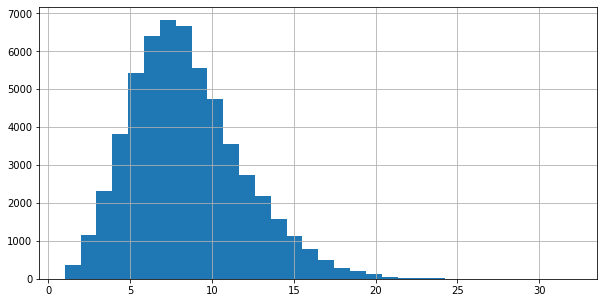

In [184]:
# Add Num_ingred column
recipes['Num_ingred'] = 32-recipes.isnull().sum(axis=1) 

# Plot distribution
recipes['Num_ingred'].hist(bins=32, figsize=(10,5));

In [185]:
# Mean
round(recipes['Num_ingred'].mean(), 4)

8.2199

Most recipes have 2 to 15 ingredients with an overall average of 8.22 ingredients per recipe.

### Average Ingredients per Cuisine

In [186]:
avg_ingdnts = recipes.groupby('Cuisine').mean().sort_values(by=['Num_ingred'], ascending=True).round(4).reset_index().iloc[:,[0,1]]
avg_ingdnts

,Cuisine,Num_ingred
0,NorthernEuropean,6.8240
1,NorthAmerican,7.9621
2,WesternEuropean,8.0259
3,EasternEuropean,8.3885
4,MiddleEastern,8.3891
5,SouthernEuropean,8.8608
6,EastAsian,8.9562
7,LatinAmerican,9.3795
8,SouthAsian,10.2866
9,African,10.4517


In [187]:
#recipes.columns

Northern European recipes have the fewest average number of ingredients at 6.82 while Southeast Asian recipes have the most ingredients per recipe on average at 11.32 ingredients.

### Distribution of Ingredients per Cuisine

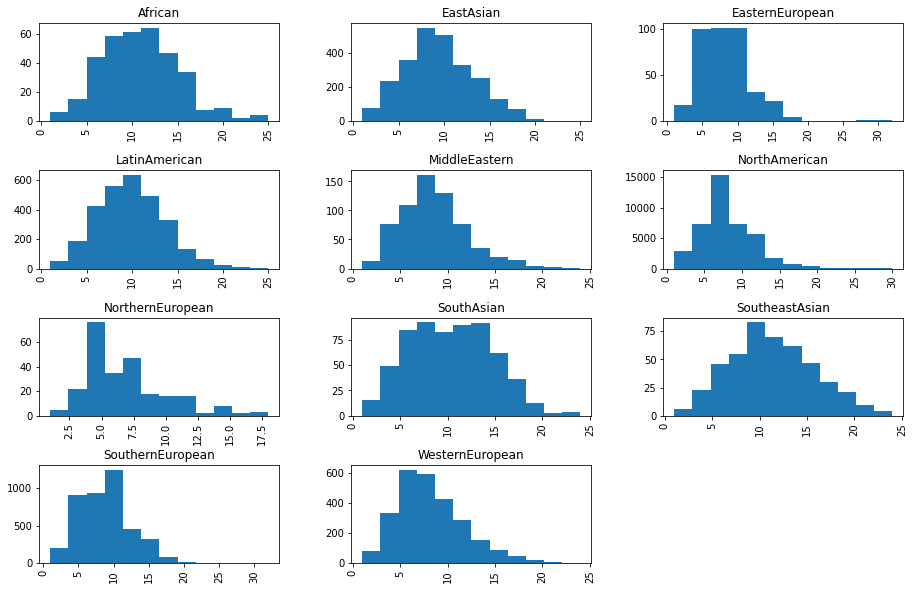

In [188]:
recipes['Num_ingred'].hist(by=recipes['Cuisine'], bins=12, figsize=(15,10));

### Counts of Ingredients

In [189]:
# Add recipe_id column 
recipes['recipe_id'] = recipes.index+1

ingredient_list = pd.melt(recipes, id_vars=['Cuisine','recipe_id'], value_vars=columns[1:]).dropna()
ingredient_list.rename(columns={"variable":"ingred_id", "value":"ingredient"}, inplace=True)
len(ingredient_list)

464407

All the 56,498 recipese contain 464,407 total ingredients.

In [190]:
#ingredient_list.head(10)

In [191]:
ingredient_counts = pd.DataFrame(ingredient_list.ingredient.value_counts())
ingredient_counts.shape

(381, 1)

There are 381 unique ingredients.

In [192]:
# Count of ingredients
ingredient_counts.head(10)

,ingredient
egg,20951
wheat,20782
butter,20744
onion,18031
garlic,16893
milk,12895
vegetable_oil,10759
cream,10152
tomato,9909
olive_oil,9844


The top most popular ingredients in order are eggs, wheat, butter, onion and garlic.

### Top 3 Most Common Ingredients by Cuisine

In [193]:
cuisine_counts = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts())
cuisine_counts.columns = ["Count"]

cuisine_counts.groupby('Cuisine').head(3) # Get top 3



Count
Cuisine          ingredient       
African          olive_oil     196
                 onion         189
                 cumin         166
EastAsian        soy_sauce    1358
                 garlic       1302
                 scallion     1188
EasternEuropean  butter        201
                 egg           197
                 wheat         197
LatinAmerican    cayenne      1946
                 onion        1906
                 garlic       1752
MiddleEastern    wheat         272
                 olive_oil     262
                 egg           239
NorthAmerican    butter      17088
                 egg         16738
                 wheat       16532
NorthernEuropean butter        160
                 wheat         145
                 egg           132
SouthAsian       cumin         375
                 turmeric      319
                 onion         316
SoutheastAsian   garlic        284
                 fish          226
                 cayenne       191
SouthernEuropean olive_oil    2612
                 garlic       2181
                 tomato       1593
WesternEuropean  butter       1395
                 egg          1303
                 wheat        1278

The top ingredient varies by cuisine however, with te overall top ingredient (egg) not taking a top slot for any cuisine.

### Ingredient Pairs

In [194]:
# Dataframe with all pairs
pairs = pd.DataFrame({'Cuisine':[], 'ingred1':[], 'ingred2':[]})
for i in range(1,32):
    for j in range((i+1),33):
        temp = recipes.iloc[:,[0,i,j]]
        temp.columns = ['Cuisine','ingred1','ingred2']
        temp = temp.dropna()
        pairs = pairs.append(temp,ignore_index=True)

pairs.dropna()
pairs.head()
pairs.shape



,Cuisine,ingred1,ingred2
0,African,chicken,cinnamon
1,African,cane_molasses,ginger
2,African,butter,pepper
3,African,olive_oil,pepper
4,African,honey,wheat
...,...,...,...
2036120,SouthernEuropean,shrimp,bell_pepper
2036121,EasternEuropean,cinnamon,egg
2036122,SouthernEuropean,shrimp,mussel
2036123,EasternEuropean,chive,egg


,Cuisine,ingred1,ingred2
0,African,chicken,cinnamon
1,African,cane_molasses,ginger
2,African,butter,pepper
3,African,olive_oil,pepper
4,African,honey,wheat


(2036125, 3)

There are 2,036,125 pairs

In [195]:
# Pair counts
pair_counts = pairs.reset_index().groupby(['Cuisine','ingred1','ingred2'], as_index=False).count()
pair_counts.rename(columns={"index":"counts"}, inplace=True)
pair_counts['total'] = pair_counts.groupby('Cuisine').counts.transform('sum')
pair_counts['percent'] = pair_counts['counts']/pair_counts['total']*100
pair_counts.head()
pair_counts.shape

,Cuisine,ingred1,ingred2,counts,total,percent
0,African,almond,anise_seed,1,20524,0.004872
1,African,almond,apricot,2,20524,0.009745
2,African,almond,barley,2,20524,0.009745
3,African,almond,bay,2,20524,0.009745
4,African,almond,bean,1,20524,0.004872


(123181, 6)

In [196]:
# Top 5 ingredient pairings sorted by percent
pair_counts.sort_values(by='percent', ascending=False, inplace=True)
pair_counts.head(5)

,Cuisine,ingred1,ingred2,counts,total,percent
76798,NorthernEuropean,butter,wheat,116,6249,1.856297
76722,NorthernEuropean,butter,egg,96,6249,1.536246
79059,NorthernEuropean,wheat,egg,85,6249,1.360218
26676,LatinAmerican,onion,cayenne,1389,134200,1.035022
18862,EasternEuropean,wheat,egg,146,14224,1.026434


In [197]:
# Top 5 ingredient pairings sorted by count
pair_counts.sort_values(by='counts', ascending=False, inplace=True)
pair_counts.head(5)

,Cuisine,ingred1,ingred2,counts,total,percent
74966,NorthAmerican,wheat,egg,10931,1395965,0.783043
43137,NorthAmerican,butter,wheat,10562,1395965,0.756609
42925,NorthAmerican,butter,egg,9294,1395965,0.665776
75032,NorthAmerican,wheat,milk,7315,1395965,0.524010
42995,NorthAmerican,butter,milk,6445,1395965,0.461688


butter - egg is the top ingredient pair when sorted by percent. wheat - egg is the top ingredient pair when sorted by count

### Top 3 pairings per cuisine

In [198]:
pair_counts.sort_values(by=['Cuisine','percent'], ascending=[True, False]).groupby('Cuisine').head(3)

,Cuisine,ingred1,ingred2,counts,total,percent
3296,African,olive_oil,cumin,120,20524,0.584681
3308,African,olive_oil,garlic,106,20524,0.516469
3344,African,olive_oil,onion,98,20524,0.477490
6851,EastAsian,cayenne,scallion,630,107684,0.585045
11868,EastAsian,scallion,garlic,620,107684,0.575759
12209,EastAsian,sesame_oil,soy_sauce,585,107684,0.543256
18862,EasternEuropean,wheat,egg,146,14224,1.026434
14918,EasternEuropean,butter,wheat,136,14224,0.956130
14817,EasternEuropean,butter,egg,131,14224,0.920979
26676,LatinAmerican,onion,cayenne,1389,134200,1.035022


## Network Analysis of Cuisines


I am going to perform network graph analysis of the following parameters for the top 3 cuisines based on number of recipes - *NorthAmerican,SouthernEuropean* and *LatinAmerican*:
*  Top ingredient pairs for each cuisine.
*  The ingredients that make up half of each cuisine's total ingredients
*  The top 50 ingredients in each cuisine.

For easier visualization, I will filter out the ingredient pairs to include the top 80-90 pairs for each cuisine.


#### Graph for North American Cuisine

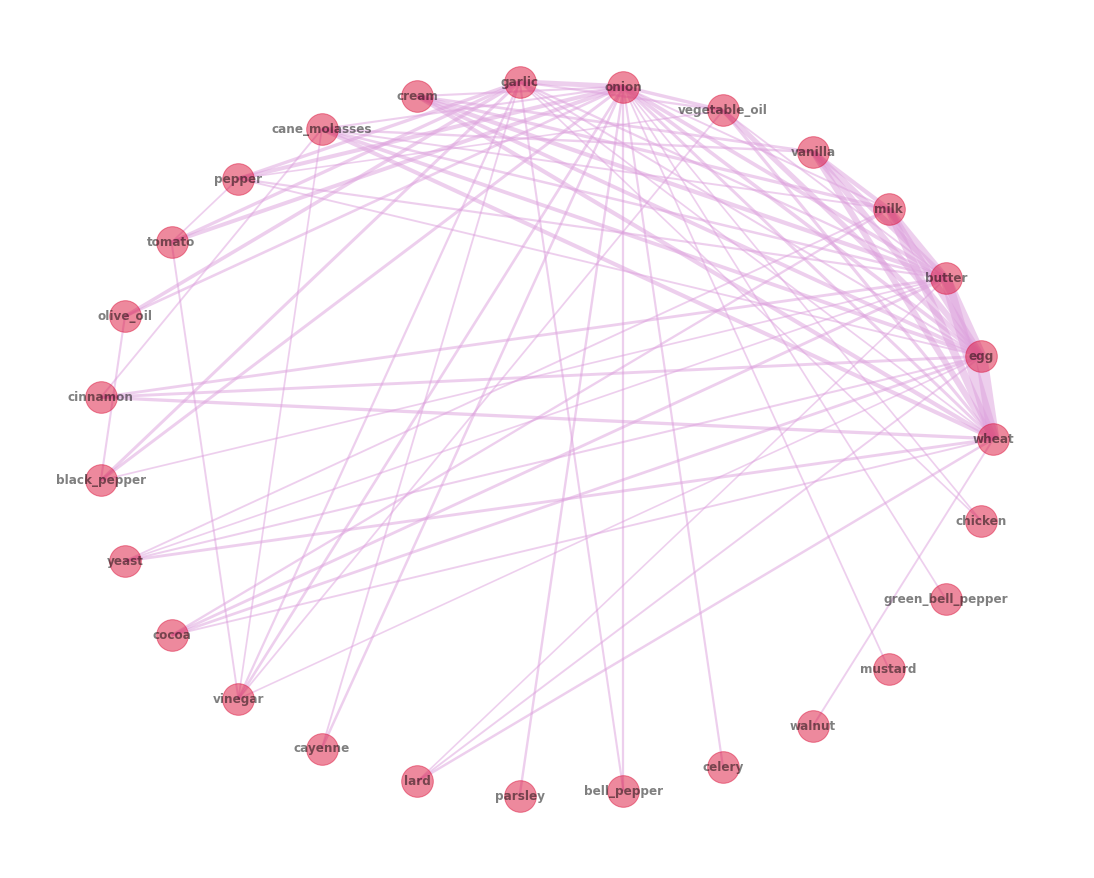

In [199]:
NA_pair_counts = pair_counts[(pair_counts['counts']>1500) & (pair_counts['Cuisine']=='NorthAmerican')]

NA_Graph=nx.from_pandas_edgelist(NA_pair_counts, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in NA_Graph.edges(data=True)]
nx.draw_circular(NA_Graph, with_labels=True, node_color="crimson", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="plum", alpha=0.5)

#### Graph for Southern European Cuisine

(83, 6)

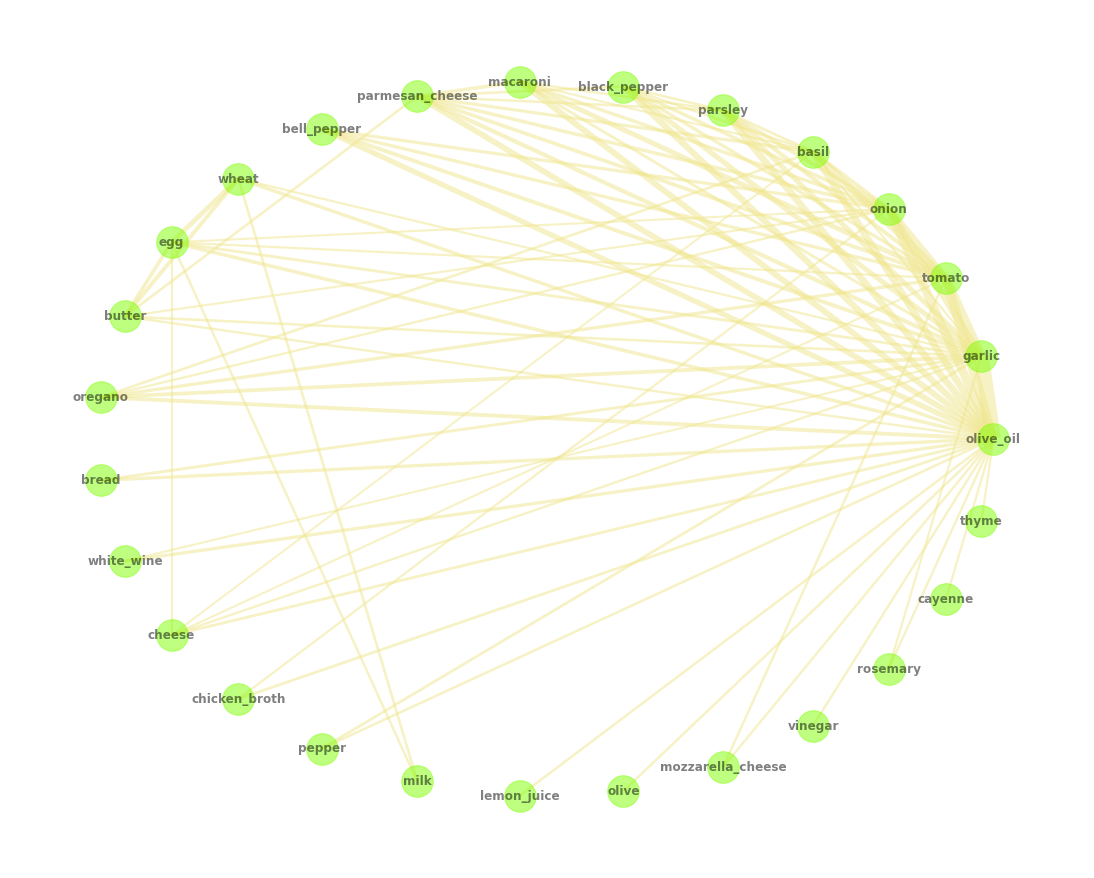

In [200]:
SE_pair_counts = pair_counts[(pair_counts['counts'] > 230) & (pair_counts['Cuisine']=='SouthernEuropean')]
SE_pair_counts.shape

SE_Graph=nx.from_pandas_edgelist(SE_pair_counts, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SE_Graph.edges(data=True)]
nx.draw_circular(SE_Graph, with_labels=True, node_color="chartreuse", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="khaki", alpha=0.5)

#### Graph for Latin American Cuisine

(86, 6)

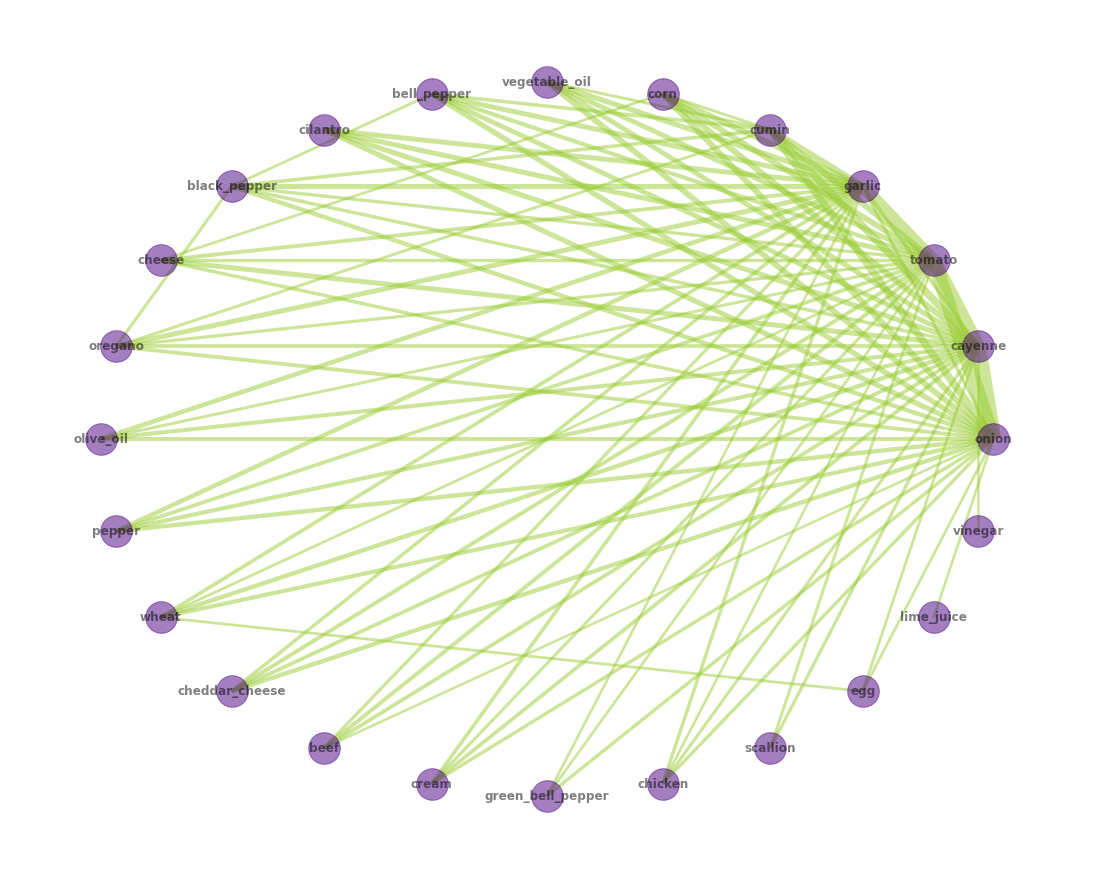

In [201]:
LA_pair_counts = pair_counts[(pair_counts['counts'] > 220) & (pair_counts['Cuisine']=='LatinAmerican')]
LA_pair_counts.shape

LA_Graph=nx.from_pandas_edgelist(LA_pair_counts, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in LA_Graph.edges(data=True)]
nx.draw_circular(LA_Graph, with_labels=True, node_color="indigo", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="yellowgreen", alpha=0.5)

## Text Analysis of Cuisines

In [202]:
# Utility functions
def initialize(category): #initialize
    fdist = nltk.FreqDist(corpus.words(categories = category))
    ingredients_sorted = sorted(list(corpus.words(categories = category)))
    return(fdist, ingredients_sorted)

def header_text(csn):
    mkdwn = Markdown("""### {csn} Cuisine""".format(csn=csn))
    return(mkdwn)

def cuisine(category, ingredients_sorted):
    ing = len(corpus.words(categories = category))
    rec = len(corpus.sents(categories = category))
    uni_ing = len(set(ingredients_sorted))
    mkdwn = Markdown("""The **{category}** recipes in the dataset have **{ing} ingredients** in total. The 
    **{rec} recipes** have **{uni_ing} unique ingredients**.""".format(category=category, ing=ing, 
                                                                       rec=rec, uni_ing=uni_ing))
    return(mkdwn)

def top_half(ingredients, fdist):
    tw=len(ingredients)
    tcount=0
    wcount=0
    for word, count in fdist.most_common():
        #tcount =tcount+count
        tcount += count
        wcount=wcount+1
        if tcount>(tw/2):
            return(wcount)
            break

def half(category, ingredients_sorted, fdist): #top_half
    top = top_half(ingredients_sorted, fdist)
    mkdwn = Markdown("""The following {top} ingredients represent **half of the total ingredients** 
    in the **{category}** recipes.""".format(top=top, category=category))
    return(mkdwn)

def nx_graph(pair_counts):
  G=nx.from_pandas_edgelist(pair_counts, 'ingred1', 'ingred2', edge_attr='percent')
  weights=[edata['percent']*15 for f,t,edata in G.edges(data=True)]
  return Markdown(display(nx.draw_circular(G, with_labels=True, node_color="indianred", node_size=1000, font_size=12,  font_weight='bold', 
          width=weights, edge_color="darksalmon", alpha=0.5)))



### African Cuisine

The **African** recipes in the dataset have **3679 ingredients** in total. The 
    **352 recipes** have **197 unique ingredients**.

The following 16 ingredients represent **half of the total ingredients** 
    in the **African** recipes.

,ingredient,count
0,olive_oil,196
1,onion,189
2,cumin,166
3,garlic,160
4,cayenne,116
5,cinnamon,114
6,wheat,114
7,coriander,104
8,bell_pepper,103
9,tomato,100


#### Top 50 Ingredients in African Cuisine

<Figure size 1224x360 with 0 Axes>

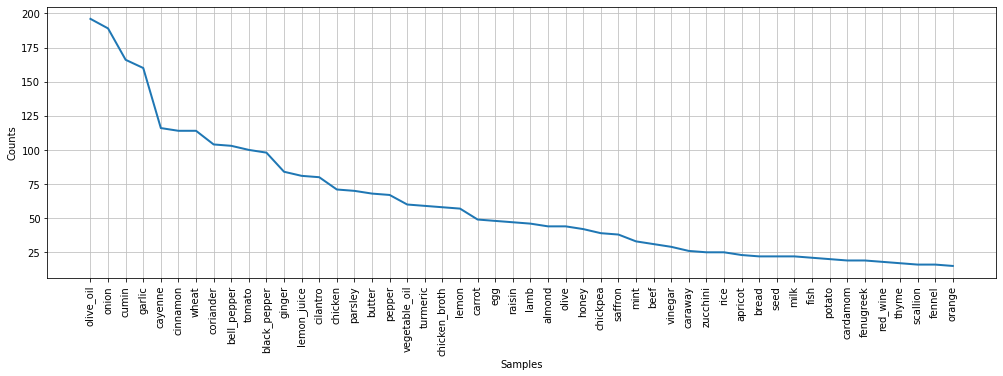

### EastAsian Cuisine

The **EastAsian** recipes in the dataset have **22498 ingredients** in total. The 
    **2512 recipes** have **242 unique ingredients**.

The following 13 ingredients represent **half of the total ingredients** 
    in the **EastAsian** recipes.

,ingredient,count
0,soy_sauce,1358
1,garlic,1302
2,scallion,1188
3,cayenne,1008
4,sesame_oil,937
5,rice,849
6,ginger,818
7,black_pepper,761
8,vegetable_oil,760
9,soybean,627


#### Top 50 Ingredients in EastAsian Cuisine

<Figure size 1224x360 with 0 Axes>

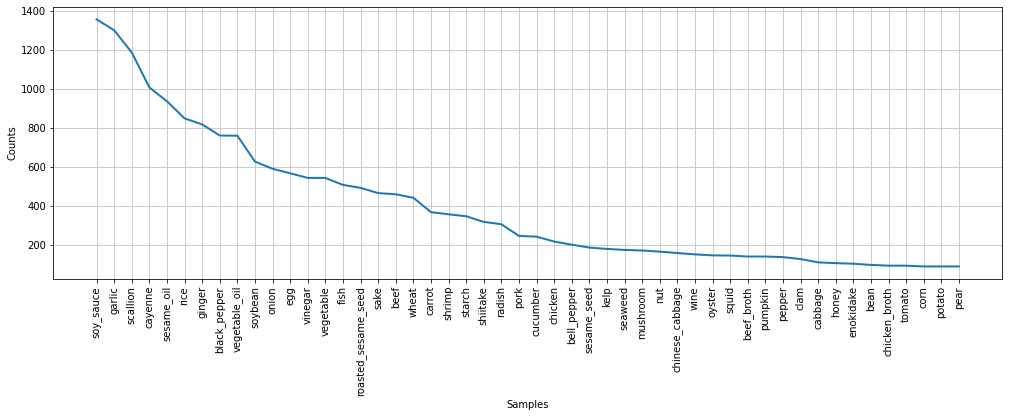

### EasternEuropean Cuisine

The **EasternEuropean** recipes in the dataset have **3195 ingredients** in total. The 
    **381 recipes** have **198 unique ingredients**.

The following 16 ingredients represent **half of the total ingredients** 
    in the **EasternEuropean** recipes.

,ingredient,count
0,butter,201
1,wheat,197
2,egg,196
3,onion,162
4,cream,111
5,milk,94
6,black_pepper,88
7,garlic,88
8,vegetable_oil,82
9,potato,73


#### Top 50 Ingredients in EasternEuropean Cuisine

<Figure size 1224x360 with 0 Axes>

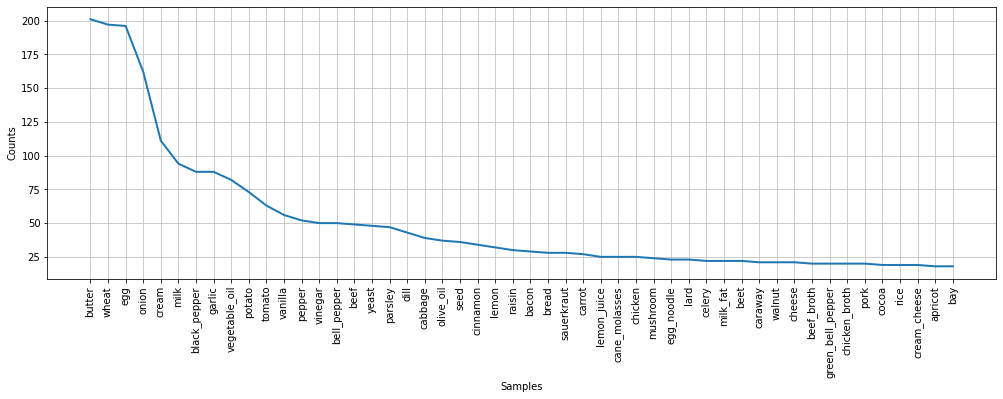

### LatinAmerican Cuisine

The **LatinAmerican** recipes in the dataset have **27360 ingredients** in total. The 
    **2917 recipes** have **260 unique ingredients**.

The following 14 ingredients represent **half of the total ingredients** 
    in the **LatinAmerican** recipes.

,ingredient,count
0,cayenne,1946
1,onion,1906
2,garlic,1752
3,tomato,1579
4,corn,868
5,cumin,833
6,vegetable_oil,732
7,cilantro,724
8,wheat,660
9,pepper,640


#### Top 50 Ingredients in LatinAmerican Cuisine

<Figure size 1224x360 with 0 Axes>

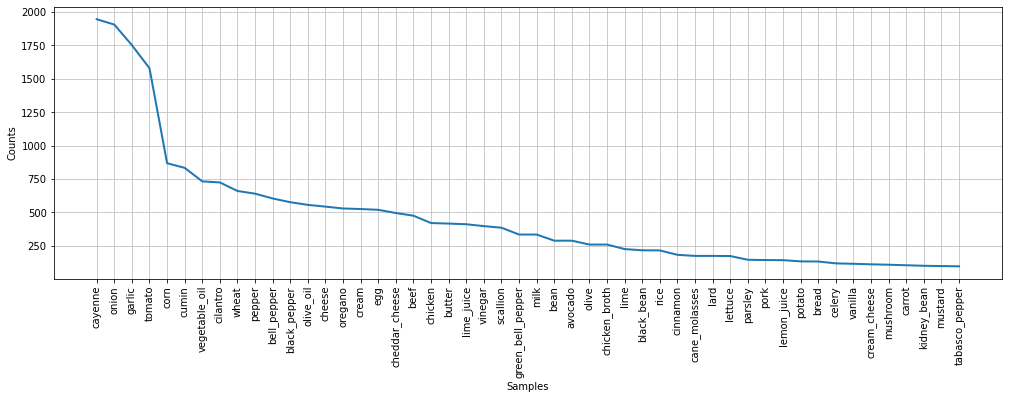

### MiddleEastern Cuisine

The **MiddleEastern** recipes in the dataset have **5411 ingredients** in total. The 
    **645 recipes** have **227 unique ingredients**.

The following 19 ingredients represent **half of the total ingredients** 
    in the **MiddleEastern** recipes.

,ingredient,count
0,wheat,272
1,olive_oil,262
2,egg,239
3,onion,221
4,garlic,212
5,butter,165
6,lemon_juice,160
7,black_pepper,145
8,parsley,134
9,vegetable_oil,132


#### Top 50 Ingredients in MiddleEastern Cuisine

<Figure size 1224x360 with 0 Axes>

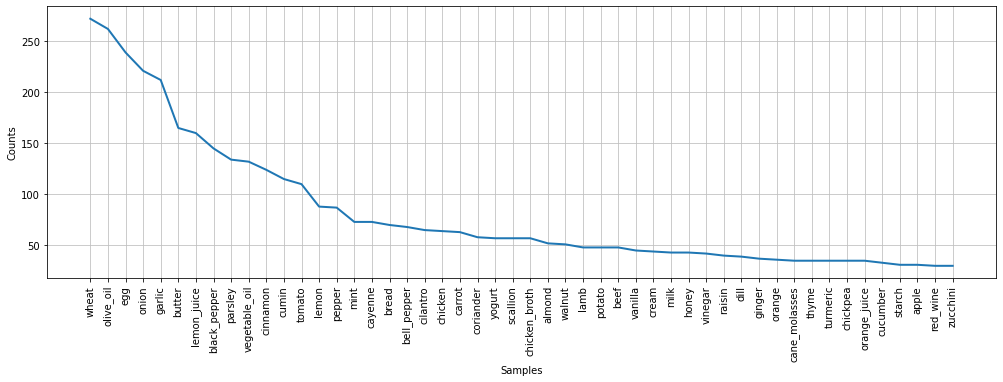

### NorthAmerican Cuisine

The **NorthAmerican** recipes in the dataset have **330618 ingredients** in total. The 
    **41524 recipes** have **354 unique ingredients**.

The following 21 ingredients represent **half of the total ingredients** 
    in the **NorthAmerican** recipes.

,ingredient,count
0,butter,17088
1,egg,16738
2,wheat,16532
3,onion,12311
4,milk,10996
5,garlic,10101
6,cream,8124
7,vanilla,8081
8,vegetable_oil,7808
9,pepper,7000


#### Top 50 Ingredients in NorthAmerican Cuisine

<Figure size 1224x360 with 0 Axes>

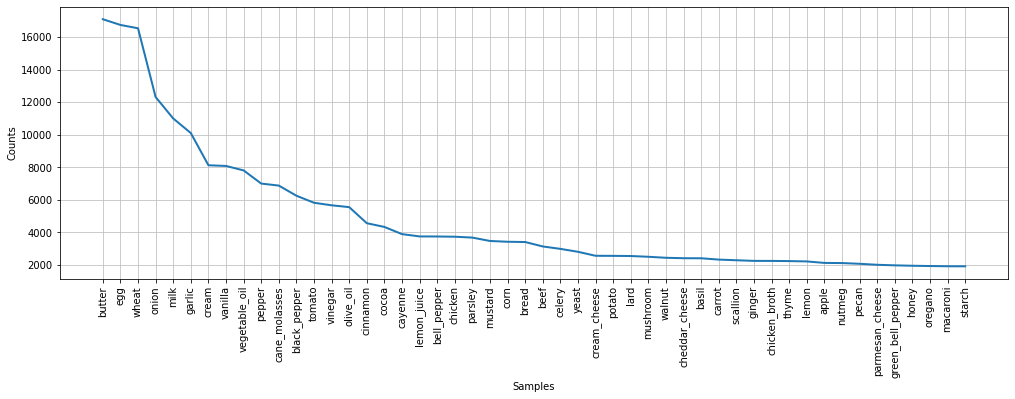

### NorthernEuropean Cuisine

The **NorthernEuropean** recipes in the dataset have **1706 ingredients** in total. The 
    **250 recipes** have **175 unique ingredients**.

The following 13 ingredients represent **half of the total ingredients** 
    in the **NorthernEuropean** recipes.

,ingredient,count
0,butter,160
1,wheat,145
2,egg,132
3,cream,72
4,milk,56
5,almond,46
6,onion,39
7,vanilla,38
8,cinnamon,38
9,vinegar,38


#### Top 50 Ingredients in NorthernEuropean Cuisine

<Figure size 1224x360 with 0 Axes>

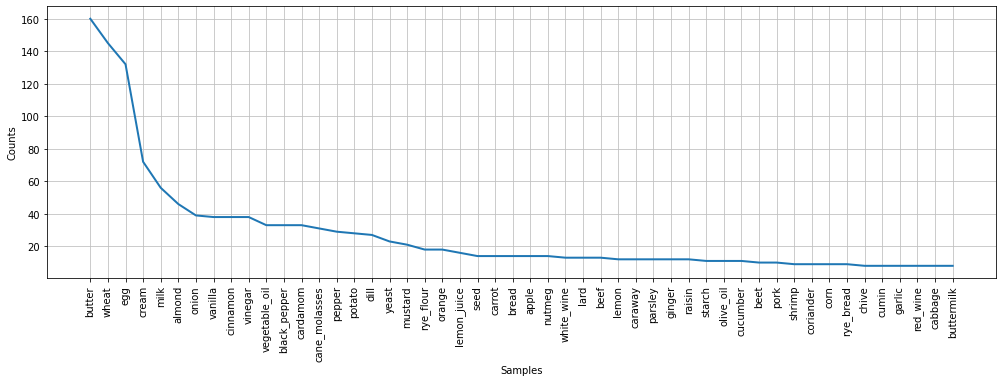

### SouthAsian Cuisine

The **SouthAsian** recipes in the dataset have **6388 ingredients** in total. The 
    **621 recipes** have **205 unique ingredients**.

The following 13 ingredients represent **half of the total ingredients** 
    in the **SouthAsian** recipes.

,ingredient,count
0,cumin,375
1,turmeric,319
2,onion,316
3,cayenne,300
4,garlic,295
5,coriander,294
6,vegetable_oil,265
7,ginger,264
8,pepper,188
9,cilantro,180


#### Top 50 Ingredients in SouthAsian Cuisine

<Figure size 1224x360 with 0 Axes>

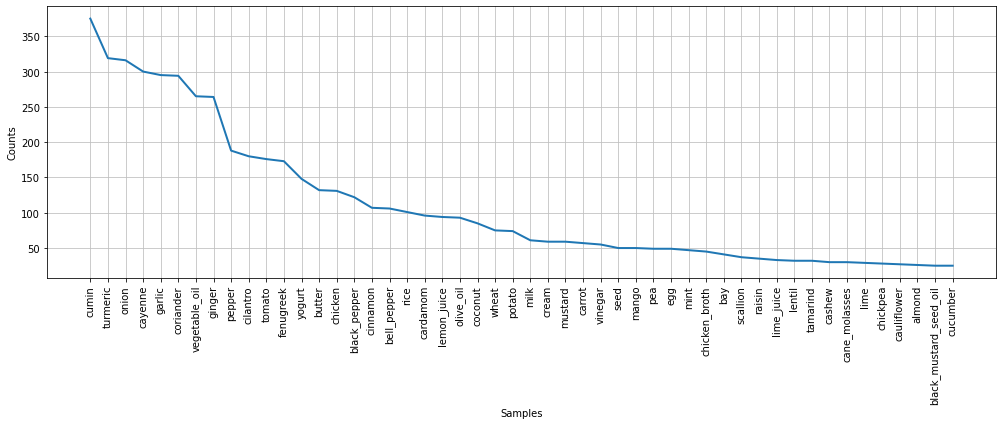

### SoutheastAsian Cuisine

The **SoutheastAsian** recipes in the dataset have **5172 ingredients** in total. The 
    **457 recipes** have **184 unique ingredients**.

The following 17 ingredients represent **half of the total ingredients** 
    in the **SoutheastAsian** recipes.

,ingredient,count
0,garlic,284
1,fish,226
2,cayenne,191
3,vegetable_oil,180
4,cilantro,163
5,rice,163
6,ginger,153
7,soy_sauce,144
8,chicken,136
9,lime_juice,132


#### Top 50 Ingredients in SoutheastAsian Cuisine

<Figure size 1224x360 with 0 Axes>

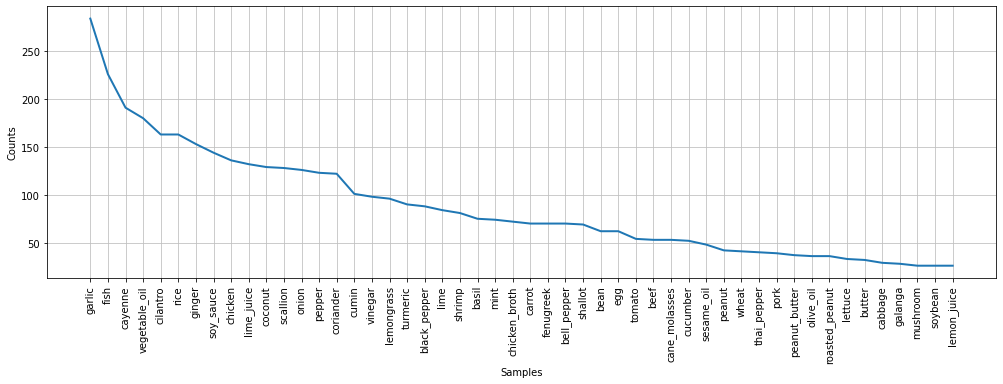

### SouthernEuropean Cuisine

The **SouthernEuropean** recipes in the dataset have **37037 ingredients** in total. The 
    **4180 recipes** have **290 unique ingredients**.

The following 16 ingredients represent **half of the total ingredients** 
    in the **SouthernEuropean** recipes.

,ingredient,count
0,olive_oil,2612
1,garlic,2181
2,tomato,1593
3,onion,1451
4,egg,1097
5,basil,1059
6,black_pepper,1039
7,wheat,1027
8,parsley,1025
9,butter,1020


#### Top 50 Ingredients in SouthernEuropean Cuisine

<Figure size 1224x360 with 0 Axes>

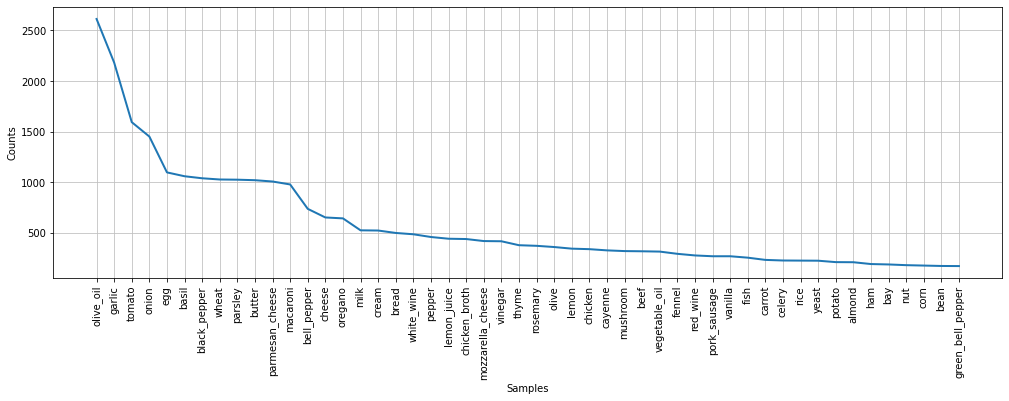

### WesternEuropean Cuisine

The **WesternEuropean** recipes in the dataset have **21341 ingredients** in total. The 
    **2659 recipes** have **309 unique ingredients**.

The following 19 ingredients represent **half of the total ingredients** 
    in the **WesternEuropean** recipes.

,ingredient,count
0,butter,1395
1,egg,1303
2,wheat,1278
3,onion,720
4,milk,693
5,cream,640
6,black_pepper,548
7,garlic,510
8,olive_oil,455
9,vegetable_oil,392


#### Top 50 Ingredients in WesternEuropean Cuisine

<Figure size 1224x360 with 0 Axes>

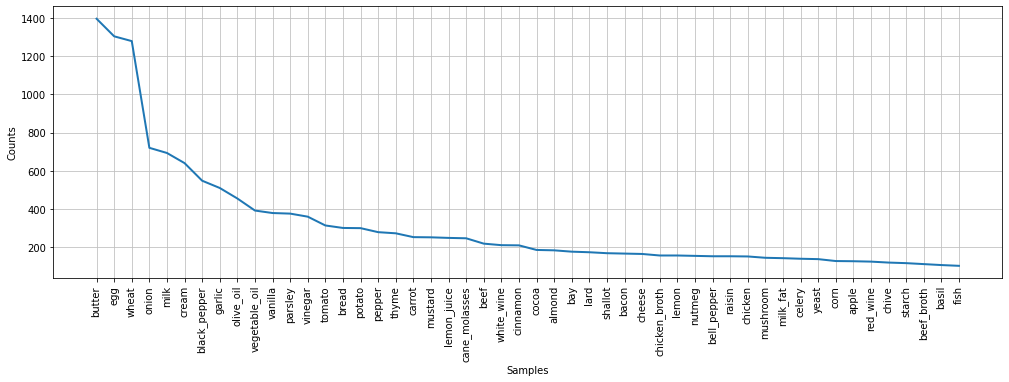

In [203]:
for csn in corpus.categories():
  header_text(csn)

  fdist, ingredients_sorted = initialize(csn) 
  cuisine(csn, ingredients_sorted)

  half(csn, ingredients_sorted, fdist)

  pd.DataFrame(fdist.most_common()[:13], columns=['ingredient', 'count'])
  
  Markdown("""#### Top 50 Ingredients in {} Cuisine""".format(csn))

  plt.figure(figsize=(17,5))
  fdist.plot(50, );




In [204]:
ctgry = "NorthAmerican"
fdist, ingredients_sorted = initialize(ctgry) 
cuisine(ctgry, ingredients_sorted)

The **NorthAmerican** recipes in the dataset have **330618 ingredients** in total. The 
    **41524 recipes** have **354 unique ingredients**.

In [205]:
half(ctgry, ingredients_sorted, fdist)

The following 21 ingredients represent **half of the total ingredients** 
    in the **NorthAmerican** recipes.

In [206]:
pd.DataFrame(fdist.most_common()[:21], columns=['ingredient', 'count'])

,ingredient,count
0,butter,17088
1,egg,16738
2,wheat,16532
3,onion,12311
4,milk,10996
5,garlic,10101
6,cream,8124
7,vanilla,8081
8,vegetable_oil,7808
9,pepper,7000


## Bipartite Network

The dataframe *ingred_percents* below represents ingredients as percent of the total number of recipes by cuisine. I will multiply the percents by 10 to get the estimated number of recipes in 1000 that would contain each ingredient in each cuisine. I will then take the top 30 ingredients from each cuisine and create a graph object from those with cuisines and ingredients as the top and bottom nodes.

In [207]:

#Top ingredients as percent of the total number of recipes by cuisine

ingred_percents = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts(normalize=True)*100)
ingred_percents.columns = ["percent"]
#ingred_percents.head()
#ingred_percents.reset_index().groupby('Cuisine').head(1).sort_values(by=['percent'], ascending=False)



In [208]:
nw = ingred_percents.groupby('Cuisine').head(30).reset_index()
nw['count_per_1000_recipes'] = round(nw['percent']*10, 0)
nw.head()

,Cuisine,ingredient,percent,count_per_1000_recipes
0,African,olive_oil,5.327535,53.0
1,African,onion,5.137266,51.0
2,African,cumin,4.512096,45.0
3,African,garlic,4.349008,43.0
4,African,cayenne,3.153031,32.0


In [209]:
# Graph
B_Gph = nx.Graph()
B_Gph.add_nodes_from(nw['Cuisine'], bipartite=0)
B_Gph.add_nodes_from(nw['ingredient'], bipartite=1)
B_Gph.add_weighted_edges_from([tuple(d) for d in nw[['Cuisine','ingredient','count_per_1000_recipes']].values])

print(nx.info(B_Gph))



Graph with 106 nodes and 330 edges


### Island Method on the Bipartite Graph

I will trim the graph into subgraphs at different minimum weight levels. Any node not connected by at least one edge with the minimum weight will be cut from the graph.

In [210]:
# Utility Functions
def edge_trim(g, weight=1): 
    gph=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            gph.add_edge(f,to,attr_dict={weight:edata['weight']})
    gph.add_nodes_from(my_list, bipartite=0)
    gph.add_nodes_from(my_list1, bipartite=1)
    return gph

def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    step=int((mx-mn)/(iterations-1)) #compute the size of the step, to get a good step between iterations 
    return [[threshold, edge_trim(g, threshold)] for threshold in range(mn,mx,step)]

In [211]:
# island_method function run for 10 iterations and a minimum weight of 20
islands = island_method(B_Gph, 10, 20)
for i in islands:
  threshold = i[0]
  graph_size = len(i[1])
  connected_compntns = len(list(B_Gph.subgraph(c) for c in nx.connected_components(i[1])))
  print("\nMinimum weight: " + str(threshold) + 
          "\nNumber of nodes: " + str(graph_size)  + 
          "\nNumber of island subgraphs: " + str(connected_compntns)
          )



Minimum weight: 20
Number of nodes: 56
Number of island subgraphs: 1

Minimum weight: 28
Number of nodes: 38
Number of island subgraphs: 1

Minimum weight: 36
Number of nodes: 30
Number of island subgraphs: 1

Minimum weight: 44
Number of nodes: 24
Number of island subgraphs: 1

Minimum weight: 52
Number of nodes: 20
Number of island subgraphs: 3

Minimum weight: 60
Number of nodes: 12
Number of island subgraphs: 3

Minimum weight: 68
Number of nodes: 9
Number of island subgraphs: 3

Minimum weight: 76
Number of nodes: 4
Number of island subgraphs: 1

Minimum weight: 84
Number of nodes: 3
Number of island subgraphs: 1

Minimum weight: 92
Number of nodes: 2
Number of island subgraphs: 1


#### Largest island subgraph

In [212]:
# Function that lets you specify colors fo the nodes
def define_colors(grph, color1, color2):
    colors = []
    for node, data in grph.nodes(data=True):
        if data['bipartite'] == 1: 
            colors.append(color1) # Airports in lightcoral    
        else:
            colors.append(color2)  # Airlines in lavender
        return colors

In [213]:
G0=islands[0][1]

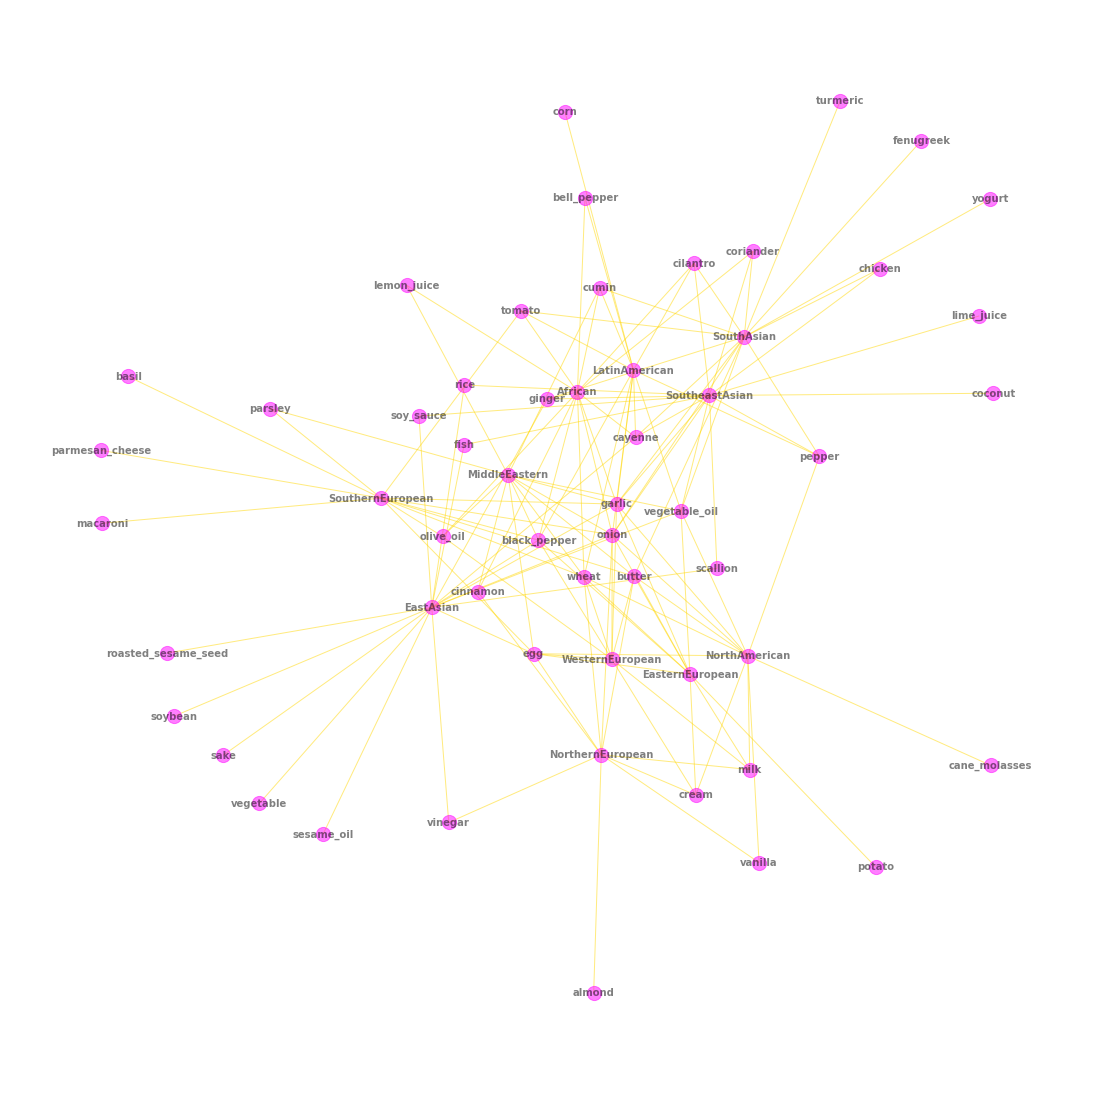

In [214]:
colors = define_colors(G0, "tomato", "magenta")
plt.rcParams["figure.figsize"] = (15,15) # set plot size

nx.draw(G0, with_labels=True, node_color=colors, node_size=200, 
        font_size=10, font_weight='bold', edge_color="gold", alpha=0.5)

From the graph above we start to see similarities and differences among. East Asian has a number of ingredients that are unique to East Asian cuisine ; same for Southeast Asian

#### Second Largest subgraph

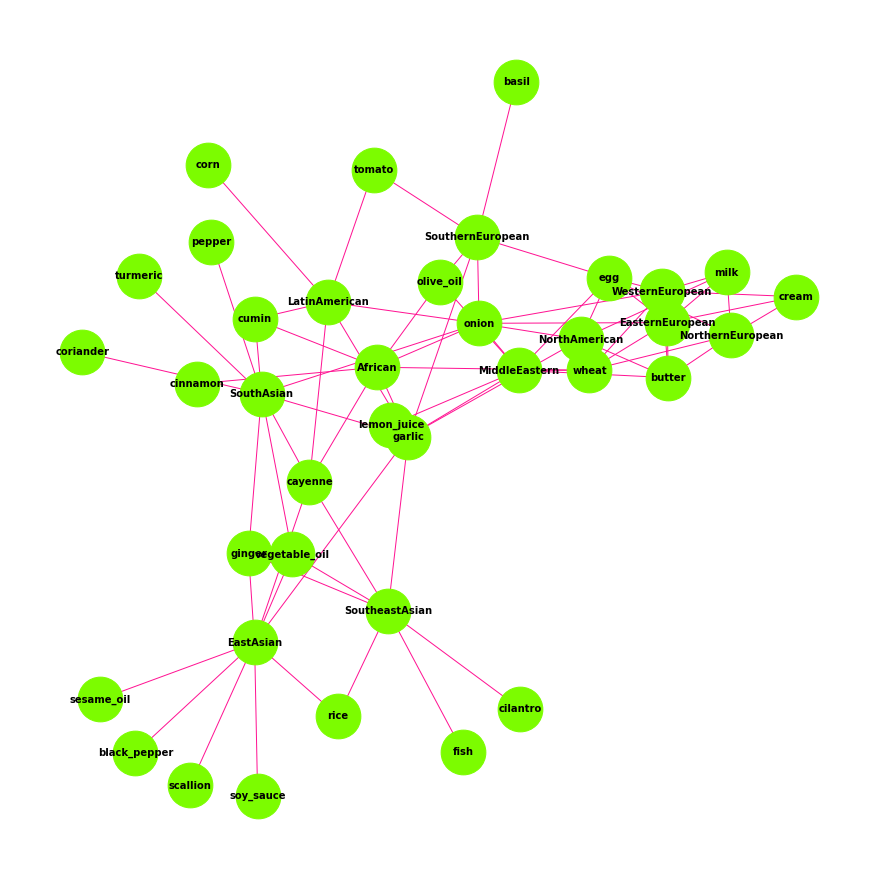

In [215]:
G1=islands[1][1]

plt.rcParams["figure.figsize"] = (12,12) # set plot size
colors = define_colors(G1, "teal", "lawngreen")  # set colors

nx.draw(G1, with_labels=True, node_color=colors, node_size=2000, 
        font_size=10, font_weight='bold', edge_color="deeppink")



Relationships become clearer in this subgraph

#### Third Largest subgraph

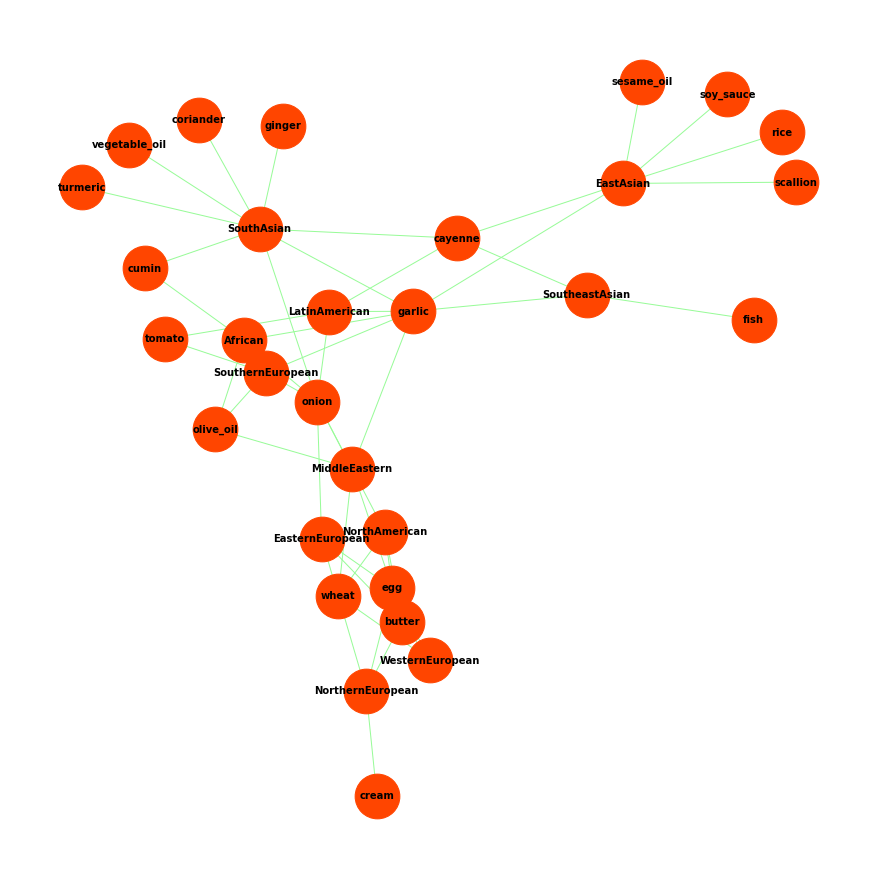

In [216]:
G2=islands[2][1]

plt.rcParams["figure.figsize"] = (12,12) # set plot size
colors = define_colors(G2, "maroon", "orangered")  # set colors

nx.draw(G2, with_labels=True, node_color=colors, node_size=2000, 
        font_size=10, font_weight='bold', edge_color="palegreen")

This graph breaks down each cuisine into it's most common ingredients.


## Conclusion

We can clearly similarities and differences among the cuisines of different cultures. Cuisines that share continents in general have more similarities - likely due to the cultural heritage.